# EC500 - Group 6 - Denoising CT Images 
**Avantika Kothandaraman, Caiwei Zhang, Long Chen**

## Section-1: Installing the necessary packages

In [1]:
pip install pynrrd

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install SimpleITK

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
!python -c "import monai" || pip install -q "monai"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
import os
import nibabel as nib
import nrrd
from torchvision.datasets import ImageFolder
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import monai.transforms as mTransforms
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    Compose
)
from tqdm import tqdm
from scipy import ndimage

## Section-2: Initial data inspection

In [5]:
# initializing directory of dataset
data_dir = '/projectnb/ec500kb/projects/Project6/scans'

In [6]:
# looping through for inspection
count = 0
dims = []
sizes = []
shapes = []
    
for filename in os.listdir(data_dir):

    if filename.endswith('.nrrd'):
        count += 1
        img, header = nrrd.read(os.path.join(data_dir,filename))
        dims.append(img.ndim)
        sizes.append(img.size)
        shapes.append(img.shape)
        
dims_check = all(dim == dims[0] for dim in dims)
sizes_check = all(size == sizes[0] for size in sizes)
shapes_check = all(shape == shapes[0] for shape in shapes)

if dims_check and sizes_check and shapes_check:
    print('Dimensions, shapes and sizes are the same for all images')
else:
    print('Dimensions, shapes and sizes NOT UNIFORM')
    
print('Total number of images in the dataset is {}'.format(count))

Dimensions, shapes and sizes NOT UNIFORM
Total number of images in the dataset is 30


In [7]:
# checking the 3D Nature of the image to analyse the axis preferred

def maximum_intensity_projection(volume, axis=0):
    return np.max(volume, axis=axis)

# Perform Maximum Intensity Projection along the z-axis (axis=0)
volume = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_dir,'L067_std.nrrd')))
mip_image = maximum_intensity_projection(volume, axis=1)
#mip_image = ndimage.rotate(mip_image, 90, reshape=False)


# Display the resulting 2D image
#plt.imshow(mip_image, cmap='gray')
#plt.colorbar()
#plt.show()

print(volume.shape)
print(mip_image.shape)

volume1 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_dir,'L067_noise.nrrd')))
mip_image1 = maximum_intensity_projection(volume1, axis=1)
print(volume1.shape)
print(mip_image1.shape)

volume2 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_dir,'L067_std.nrrd')))
mip_image2 = maximum_intensity_projection(volume2, axis=1)
print(volume2.shape)
print(mip_image2.shape)

#resize = transforms.Resize((64,64))
#r1, r2, r3 = resize(mip_image), resize(mip_image1), resize(mip_image2)
#print(r1.shape,r2.shape,r3.shape)

(560, 512, 512)
(560, 512)
(560, 512, 512)
(560, 512)
(560, 512, 512)
(560, 512)


(560, 512, 512)
(560, 512)
torch.Size([1, 512, 512])


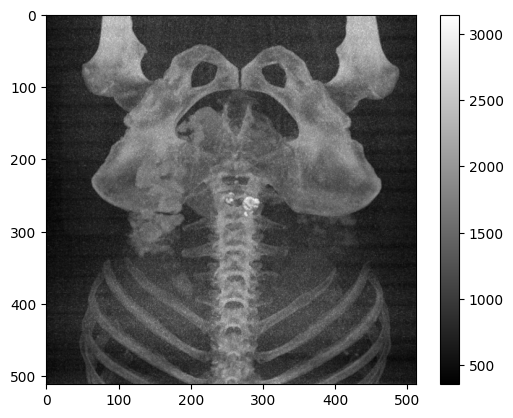

In [8]:
# running experiments to see the kind of transformation that is to be applied before giving as inout to the UNet

volume = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_dir,'L067_signal.nrrd')))
volume1 = maximum_intensity_projection(volume, axis=1)

noise = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_dir,'L067_noise.nrrd')))
noise1 = maximum_intensity_projection(noise, axis=1)

print(volume.shape)
print(volume1.shape)

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512))
])

volume2 = trans(volume1)
noise2 = trans(noise1)

print(volume2.shape)

#plt.imshow(volume2.squeeze().cpu().numpy(), cmap='gray')
#plt.colorbar()
#plt.show()

#k = random.uniform(0,5)
ct_generated = volume2 + (5*noise2)
plt.imshow(ct_generated.squeeze().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()


In [9]:
print(dims)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [10]:
print(sizes)

[83361792, 83361792, 215744512, 137887744, 159907840, 215744512, 157286400, 137625600, 146800640, 224395264, 146800640, 159907840, 157286400, 159907840, 153354240, 83361792, 137625600, 137887744, 137887744, 215744512, 137625600, 157286400, 224395264, 139722752, 153354240, 139722752, 146800640, 139722752, 153354240, 224395264]


In [11]:
print(shapes)

[(512, 512, 318), (512, 512, 318), (512, 512, 823), (512, 512, 526), (512, 512, 610), (512, 512, 823), (512, 512, 600), (512, 512, 525), (512, 512, 560), (512, 512, 856), (512, 512, 560), (512, 512, 610), (512, 512, 600), (512, 512, 610), (512, 512, 585), (512, 512, 318), (512, 512, 525), (512, 512, 526), (512, 512, 526), (512, 512, 823), (512, 512, 525), (512, 512, 600), (512, 512, 856), (512, 512, 533), (512, 512, 585), (512, 512, 533), (512, 512, 560), (512, 512, 533), (512, 512, 585), (512, 512, 856)]


#### It can be seen that the dimensions are the same throughout (3D). However, the shapes and sizes differ somewhat. 

## Step-3: Creating a Custom Dataset to fix these issues

In [12]:
# creating a Custom Dataset to load the images

class CustomData(torch.utils.data.Dataset):
    
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.data = []
        self.transform = transform
        
        for file in os.listdir(self.root_dir):
            if file.endswith('signal.nrrd'):
                image_id = file.split('_')[0] # this is to extract the image id (ex., L067)
                
                # reading as .nrrd images and converting to 2D
                signal_nrrd = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(self.root_dir, file)))
                noise_nrrd = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(self.root_dir, f"{image_id}_noise.nrrd")))
                std_nrrd = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(self.root_dir, f"{image_id}_std.nrrd")))
                
                signal_nrrd = np.max(signal_nrrd, axis=1)
                noise_nrrd = np.max(noise_nrrd, axis=1)
                std_nrrd = np.max(std_nrrd, axis=1)
                
                #
                trans = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((64,64))
                ])
                
                # converting to PyTorch tensors and resizing
                signal = trans(signal_nrrd)
                noise = trans(noise_nrrd)
                std = trans(std_nrrd)
               
                # generating new images with added noise
                k = random.uniform(0,5)
                ct_generated = signal + (k*noise)

                # applying transforms if specified
                if self.transform:
                    std = self.transform(std)
                    ct_generated = self.transform(ct_generated)
                        
                # store the images in a dictionary format
                self.data.append({'ct_generated' : ct_generated,
                                  'std_map' : std})
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [13]:
# applying transforms for data augmentation

aug_transform = Compose([
    #mTransforms.Resize((64,64)),
    #mTransforms.RandFlip(spatial_axis = 0, prob = 0.5),
    mTransforms.RandRotate(range_x=(-np.pi/12, np.pi/12), prob = 0.5, keep_size = True)
])

In [14]:
custom_dataset = CustomData(root_dir=data_dir, transform=aug_transform)

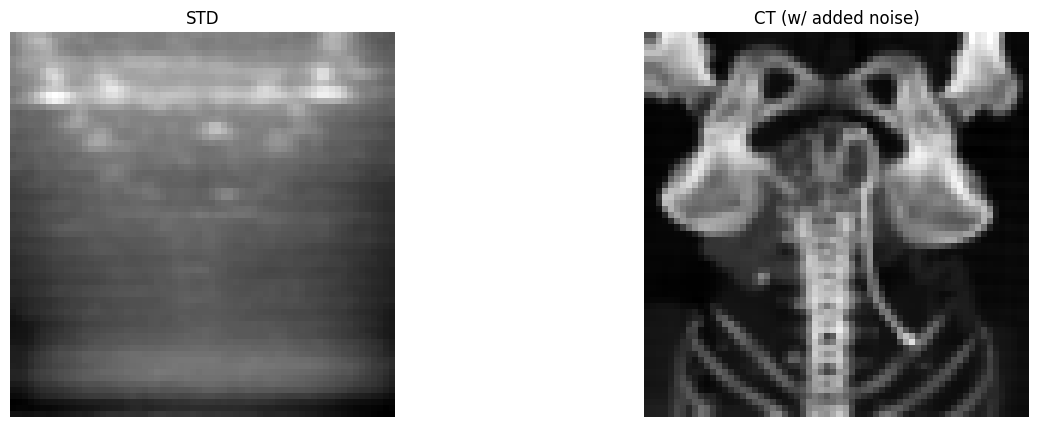

In [15]:
# Plotting a random entry in the dataset

first_entry = custom_dataset[3]

# Plot the images
plt.figure(figsize=(15, 5))

# Plot the std image
plt.subplot(1, 2, 1)
plt.imshow(first_entry['std_map'][0], cmap='gray')
plt.title('STD')
plt.axis('off')

# Plot the std image
plt.subplot(1, 2, 2)
plt.imshow(first_entry['ct_generated'][0], cmap='gray')
plt.title('CT (w/ added noise)')
plt.axis('off')

plt.show()

### Train-test-validation split

In [16]:
# splitting into train-test-validation sets (80-10-10)

train_data, testval_data = train_test_split(custom_dataset, test_size=0.2, random_state=42)

test_data, val_data = train_test_split(testval_data, test_size=0.5, random_state=42)

# creating DataLoader objects for train, validation, and test sets
train_loader = DataLoader(train_data, batch_size=5, shuffle=True, num_workers = 10)
val_loader = DataLoader(val_data, batch_size=5)
test_loader = DataLoader(test_data, batch_size=5)

# Section-4: Implement ResNet Backbone and RetinaNet 

In [109]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
}


def resnet18(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18'], model_dir='.'), strict=False)
    return model

In [110]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [112]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 1):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=1,
                                   out_channels=64,
                                   kernel_size=7,
                                   stride=2, 
                                   padding=3, 
                                   bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        )
        self.output_activation = nn.Sigmoid()  # Use if output is expected to be [0,1]


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.upconv(x)
        x = self.output_activation(x)
        return x
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    

In [113]:
num_classes = 10
num_epochs = 10
batch_size = 16
learning_rate = 0.01

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

In [114]:
# Loss and optimizer
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [115]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        optimizer.zero_grad()
        y_pred = model(img)
        print(img.size())
        print(y_pred.size())
        loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)
            val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])


100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


torch.Size([3, 1, 64, 64])
torch.Size([3, 1, 64, 64])


100%|██████████| 1/1 [00:00<00:00, 130.52it/s]


Epoch [1/10], Train Loss: 5539.3101, Validation Loss: 4621.6377


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])
torch.Size([3, 1, 64, 64])
torch.Size([3, 1, 64, 64])


100%|██████████| 1/1 [00:00<00:00, 143.87it/s]


Epoch [2/10], Train Loss: 5539.3068, Validation Loss: 4621.6318


100%|██████████| 2/2 [00:00<00:00,  7.39it/s]


torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])
torch.Size([3, 1, 64, 64])
torch.Size([3, 1, 64, 64])


100%|██████████| 1/1 [00:00<00:00, 144.49it/s]


Epoch [3/10], Train Loss: 5539.3008, Validation Loss: 4621.6240


100%|██████████| 2/2 [00:00<00:00,  7.38it/s]


torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])
torch.Size([3, 1, 64, 64])
torch.Size([3, 1, 64, 64])


100%|██████████| 1/1 [00:00<00:00, 147.42it/s]


Epoch [4/10], Train Loss: 5539.2916, Validation Loss: 4621.6128


100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])
torch.Size([3, 1, 64, 64])
torch.Size([3, 1, 64, 64])


100%|██████████| 1/1 [00:00<00:00, 136.36it/s]


Epoch [5/10], Train Loss: 5539.2812, Validation Loss: 4621.6006


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])
torch.Size([3, 1, 64, 64])
torch.Size([3, 1, 64, 64])


100%|██████████| 1/1 [00:00<00:00, 135.79it/s]


Epoch [6/10], Train Loss: 5539.2686, Validation Loss: 4621.5879


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])
torch.Size([3, 1, 64, 64])
torch.Size([3, 1, 64, 64])


100%|██████████| 1/1 [00:00<00:00, 143.98it/s]


Epoch [7/10], Train Loss: 5539.2555, Validation Loss: 4621.5732


100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])
torch.Size([3, 1, 64, 64])
torch.Size([3, 1, 64, 64])


100%|██████████| 1/1 [00:00<00:00, 144.81it/s]


Epoch [8/10], Train Loss: 5539.2408, Validation Loss: 4621.5576


100%|██████████| 2/2 [00:00<00:00,  7.16it/s]


torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])
torch.Size([3, 1, 64, 64])
torch.Size([3, 1, 64, 64])


100%|██████████| 1/1 [00:00<00:00, 144.58it/s]


Epoch [9/10], Train Loss: 5539.2258, Validation Loss: 4621.5430


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])
torch.Size([3, 1, 64, 64])
torch.Size([3, 1, 64, 64])


100%|██████████| 1/1 [00:00<00:00, 135.79it/s]

Epoch [10/10], Train Loss: 5539.2104, Validation Loss: 4621.5273


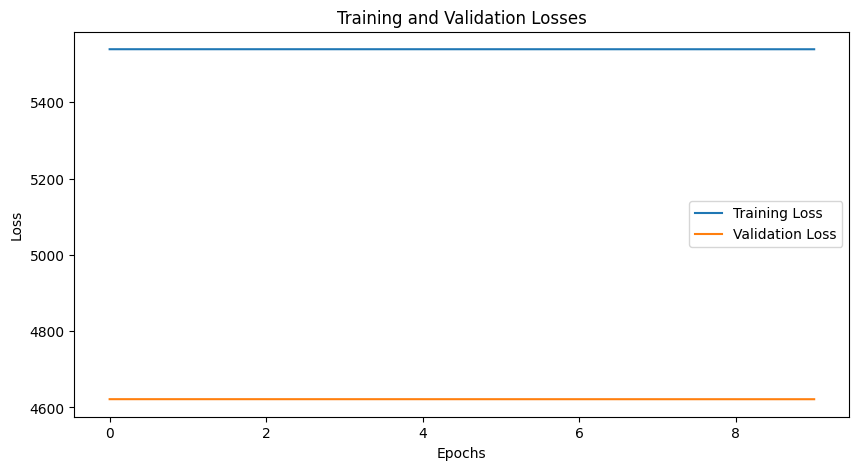

In [116]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [117]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for images in test_loader:
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)

        y_pred = model(img)
        loss = criterion(y_pred, std_map)
        test_loss += loss.item() * img.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 6927.6519


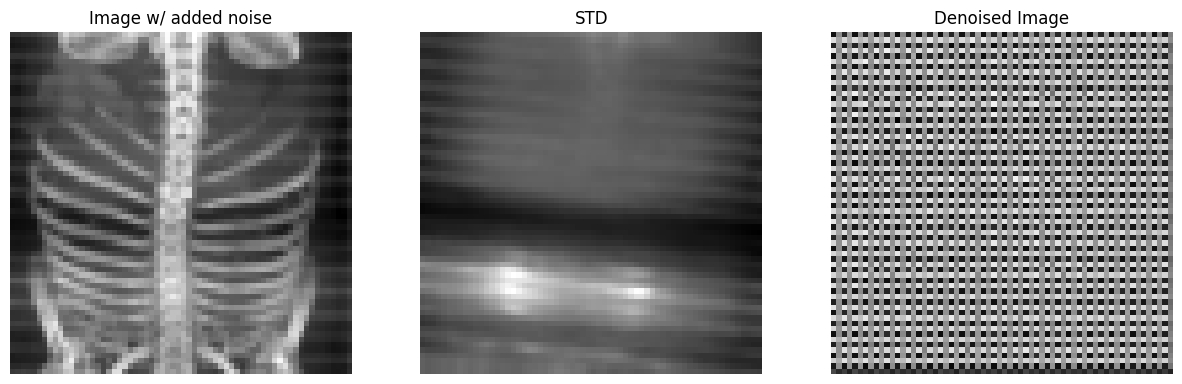

In [118]:
# model in evaluation mode
model.eval()

# get a batch from the test dataset
test_iter = iter(test_loader)
images = next(test_iter)

noisy_image = images['ct_generated'].float() 
std_image = images['std_map'].float() 

# select the first image in the batch
noisy_image_single = noisy_image[0].unsqueeze(0).to(device)  
std_image_single = std_image[0].to(device)

# Pass the noisy image through the model
with torch.no_grad():
    denoised_image = model(noisy_image_single)

# Move images back to CPU for visualization
noisy_image_cpu = noisy_image_single.squeeze(0).cpu() 
denoised_image_cpu = denoised_image.squeeze(0).cpu()
std_image_cpu = std_image_single.cpu()

# Plotting the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(noisy_image_cpu[0], cmap='gray') 
plt.title('Image w/ added noise')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(std_image_cpu[0], cmap='gray')  
plt.title('STD')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image_cpu[0], cmap='gray') 
plt.title('Denoised Image')
plt.axis('off')


plt.show()


# Section-5: Simulating a preliminary UNet

In [37]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv_op(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self,x):
        down = self.conv(x)
        p = self.pool(down)
        
        return down, p
    
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2],1)
        
        return self.conv(x)   

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.down_convolution1 = DownSample(in_channels, 64)
        self.down_convolution2 = DownSample(64, 128)
        self.down_convolution3 = DownSample(128, 256)
        self.down_convolution4 = DownSample(256, 512)
        
        self.bottleneck = DoubleConv(512, 1024)
        
        self.up_convolution1 = UpSample(1024, 512)
        self.up_convolution2 = UpSample(512, 256)
        self.up_convolution3 = UpSample(256, 128)
        self.up_convolution4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)
        
        
    def forward(self, x):
        down1, p1 = self.down_convolution1(x)
        down2, p2 = self.down_convolution2(p1)
        down3, p3 = self.down_convolution3(p2)
        down4, p4 = self.down_convolution4(p3)
        
        b = self.bottleneck(p4)
        
        up1 = self.up_convolution1(b, down4)
        up2 = self.up_convolution2(up1, down3)
        up3 = self.up_convolution3(up2, down2)
        up4 = self.up_convolution4(up3, down1)
        
        out = self.out(up4)
        
        return out
        

In [16]:
# initializing the model and optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(in_channels = 1, num_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model_saving_path = '/projectnb/ec500kb/projects/Project6/'

In [17]:
# initializing the loss function

criterion = nn.MSELoss()

In [19]:
# training loop

num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0
    for idx, images in enumerate(tqdm(train_loader)):
        
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        loss = criterion(y_pred, std_map)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = running_loss / idx+1
    
    
    model.eval()
    val_loss1 = 0
    running_val_loss = 0

    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)
            val_loss1 += criterion(y_pred, std_map)
            running_val_loss += val_loss1.item()

        val_loss1 = running_val_loss / (idx + 1)
        
    print("-"*30)
    print(f"Train loss EPOCH {epoch+1}: {train_loss: .4f}")
    print(f"Validation loss EPOCH {epoch+1}: {val_loss1: .4f}")
    print("-"*30)


100%|██████████| 2/2 [00:00<00:00,  9.83it/s]

 10%|█         | 1/10 [00:00<00:01,  4.68it/s]

------------------------------
Train loss EPOCH 1:  66411437.0000
Validation loss EPOCH 1:  23126388.0000
------------------------------



100%|██████████| 2/2 [00:00<00:00, 10.32it/s]

 20%|██        | 2/10 [00:00<00:01,  4.80it/s]

------------------------------
Train loss EPOCH 2:  65152435.0000
Validation loss EPOCH 2:  23019120.0000
------------------------------



100%|██████████| 2/2 [00:00<00:00,  9.56it/s]

 30%|███       | 3/10 [00:00<00:01,  4.69it/s]

------------------------------
Train loss EPOCH 3:  67810631.0000
Validation loss EPOCH 3:  22878554.0000
------------------------------



100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

 40%|████      | 4/10 [00:00<00:01,  4.66it/s]

------------------------------
Train loss EPOCH 4:  64899273.0000
Validation loss EPOCH 4:  22616680.0000
------------------------------



100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.67it/s]

------------------------------
Train loss EPOCH 5:  67874087.0000
Validation loss EPOCH 5:  21391976.0000
------------------------------



100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.69it/s]

------------------------------
Train loss EPOCH 6:  60839723.0000
Validation loss EPOCH 6:  11819895.0000
------------------------------



100%|██████████| 2/2 [00:00<00:00, 10.25it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.75it/s]

------------------------------
Train loss EPOCH 7:  30764437.0000
Validation loss EPOCH 7:  157934496.0000
------------------------------



100%|██████████| 2/2 [00:00<00:00,  9.68it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.71it/s]

------------------------------
Train loss EPOCH 8:  108660943.0000
Validation loss EPOCH 8:  4345977.0000
------------------------------



100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.69it/s]

------------------------------
Train loss EPOCH 9:  28068823.0000
Validation loss EPOCH 9:  14174602.0000
------------------------------



100%|██████████| 2/2 [00:00<00:00, 10.28it/s]

100%|██████████| 10/10 [00:02<00:00,  4.72it/s]

------------------------------
Train loss EPOCH 10:  49593353.0000
Validation loss EPOCH 10:  18713530.0000
------------------------------
